In [1]:
import os

In [27]:
from avapi.carla import CarlaScenesManager


cpath = os.path.join("/data/shared/CARLA/multi-agent-v1/")
# cpath = "../examples/sim_results"
CSM = CarlaScenesManager(cpath)
print(CSM.scenes)
CDM = CSM.get_scene_dataset_by_index(0)
print(f"{len(CDM)} frames")

['run-2024-03-28_16:00:36']
1072 frames


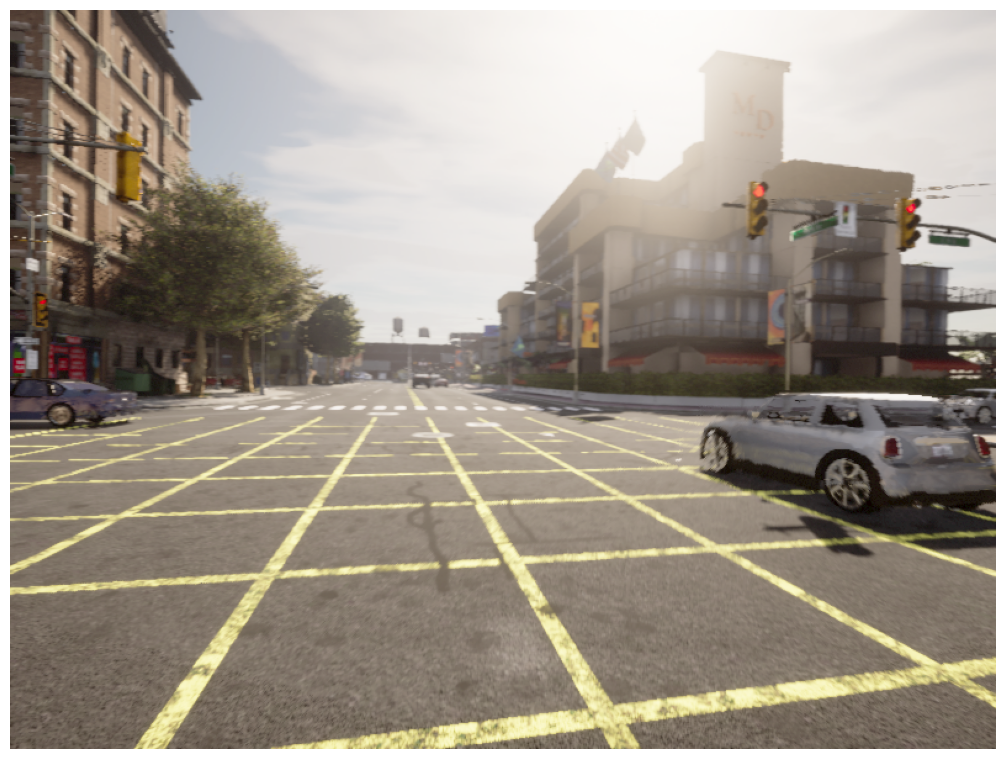

In [30]:
from avapi.visualize.snapshot import show_lidar_bev_with_boxes, show_lidar_on_image, show_image_with_boxes

agent = 0
frame_idx = 60
camera_sensor = "camera-1"
# lidar_sensor = "lidar-0"
frame = CDM.get_frames(sensor=camera_sensor, agent=agent)[frame_idx]
img = CDM.get_image(frame=frame, sensor=camera_sensor, agent=agent)
# pc = CDM.get_lidar(frame=frame, sensor=lidar_sensor, agent=agent)
# objs = CDM.get_objects(frame=frame, sensor=lidar_sensor, agent=agent)
# show_lidar_bev_with_boxes(pc=pc, boxes=objs)
# show_lidar_on_image(img=img, pc=pc, boxes=objs)
im_out = show_image_with_boxes(img=img, boxes=[], inline=True, return_image=True)



In [29]:
import sys
import numpy
from PIL import Image

result = Image.fromarray(im_out)
result.save('out.png')

In [18]:
im_out.tofile("img_out.png")

## Test a tracking scenario

In [ ]:
from avstack.geometry import Sphere, Circle

from avstack.modules.perception.object3d import Passthrough3DObjectDetector
from avstack.modules.tracking.tracker3d import BasicBoxTracker3D
from avstack.modules.tracking.multisensor import MeasurementBasedMultiTracker

from avapi.visualize.snapshot import show_lidar_bev_with_boxes, show_boxes_bev


# init models
agents = [0, 1, 2]
percep = Passthrough3DObjectDetector()
trackers = {agent: BasicBoxTracker3D() for agent in agents}
trackers["central"] = MeasurementBasedMultiTracker(tracker=BasicBoxTracker3D())

# run loop
dets = {}
tracks = {}
for frame in CDM.frames[:500]:
    # run perception and individual trackers
    found_data = False
    fovs = {}
    platforms = {}
    for agent in agents:
        try:
            lidar_sensor = "lidar-0"
            objs = CDM.get_objects(frame=frame, sensor=lidar_sensor, agent=agent)
            calib = CDM.get_calibration(frame=frame, sensor=lidar_sensor, agent=agent)
            fovs[agent] = Sphere(radius=100)
            platforms[agent] = calib.reference
        except FileNotFoundError:
            continue
        found_data = True
        dets[agent] = percep(objs)
        tracks[agent] = trackers[agent](dets[agent], platform=calib.reference)
    
    # run central tracker on all detections
    if found_data:
        tracks["central"] = trackers["central"](
            detections=dets,
            fovs=fovs,
            platforms=platforms,
        )


#### Verify that the union of the two is similar to the central

In [ ]:
from avstack.geometry import GlobalOrigin3D

tracks_all = tracks[0]+tracks[1]
tracks_all = [track.change_reference(GlobalOrigin3D, inplace=False) for track in tracks_all]
show_boxes_bev(boxes=tracks_all)
show_boxes_bev(boxes=tracks["central"])

In [ ]:
show_lidar_bev_with_boxes(pc=pc, boxes=tracks_all)
show_lidar_bev_with_boxes(pc=pc, boxes=tracks["central"])